In [1]:

import matplotlib.pyplot as plt
import numpy as np

from scipy import ndimage as ndi
from scipy import fft, ifft
import scipy

from skimage import data
from skimage import io, transform
from skimage.util import img_as_float, pad
from skimage.filters import gabor_kernel

import pickle 
import os
import sys
import h5py
import warnings
import time

import llorg_utils as l
sys.path.append('/user_data/mmhender/coco_annot/cocoapi/PythonAPI/')
from pycocotools.coco import COCO


(224, 224, 3)

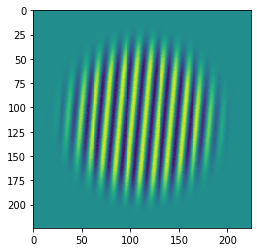

In [19]:
# load a test grating image to start with
grating_im_dir = '/user_data/mmhender/grating_ims'
orient = 5
fn2load = os.path.join(grating_im_dir, 'Grating_ex0_phase0_%ddeg.png'%orient)
grating_im  = io.imread(fn2load)
plt.figure();
plt.pcolormesh(grating_im[:,:,0])
plt.axis('square')
plt.gca().invert_yaxis()
np.shape(grating_im)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


(425, 425, 3)

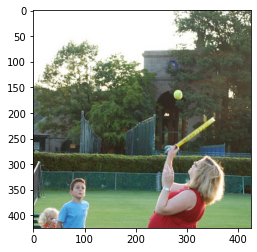

In [2]:
# load a test COCO image to start with
annot_file = '/user_data/mmhender/coco_annot/annotations/instances_val2017.json'
coco_val = COCO(annot_file)
coco=coco_val
coco_image_dir = '/lab_data/tarrlab/common/datasets/COCO/val2017'
nsd_ind = 9 # index into the 73000 NSD images
# gather metadata for these images and load the one of interest
nsd_brick_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'
nsd_meta_file = '/lab_data/tarrlab/common/datasets/NSD/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'
with h5py.File(nsd_brick_file, "r") as f:
    nsd_im = f['imgBrick'][nsd_ind,:,:,:]   
with open(nsd_meta_file,'rb') as f:
    stim_info = pickle.load(f,encoding="latin1")
    
# from metadata, get the COCO Id number of the image
coco_id_code = stim_info['cocoId'][nsd_ind]
coco_im_info = coco.loadImgs(ids=[coco_id_code])
imfn = os.path.join(coco_image_dir, coco_im_info[0]['file_name'])
coco_im = io.imread(imfn)

plt.figure();
plt.imshow(nsd_im)

np.shape(nsd_im)

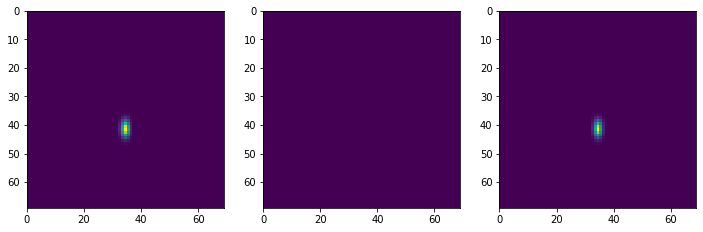

In [6]:
# Test my frequency-domain gabor filters

freq_cpp = 0.1
orient_deg = 90
gabor = l.makeFreqGabor(orient_deg, freq_cpp, spat_freq_bw=1, spat_aspect_ratio=0.5, n_sd_out=3)

plt.figure(figsize=(12,8));
plt.subplot(2,3,1)
plt.pcolormesh(np.real(gabor))
plt.axis('square')
plt.gca().invert_yaxis()


plt.subplot(2,3,2)
plt.pcolormesh(np.imag(gabor))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,3,3)
plt.pcolormesh(np.abs(gabor))
plt.axis('square')
plt.gca().invert_yaxis()


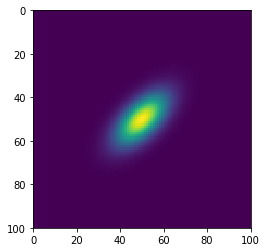

In [7]:
# Testing gaussian blob maker
image_size = [100,100]
center_pix = [49.5, 49.5]
sd_pix = [5,10]
gauss = l.gauss_2d(center_pix, sd_pix, image_size, orient_deg=45)
plt.figure();
plt.pcolormesh(gauss)
plt.axis('square')
plt.gca().invert_yaxis()

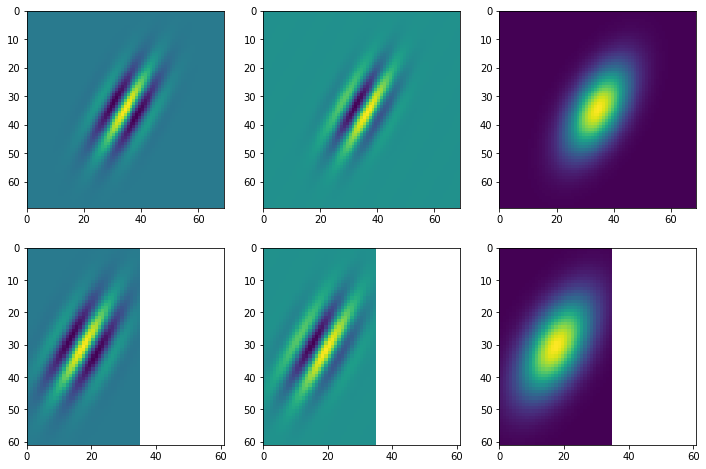

In [8]:
# Visualize an example spatial filter (my method), and compare it to the gabor_kernel function...
# Note that my filter is always square so that it will be same size for all orients.

freq_cpp = 0.1
orient_deg = 30

gabor = l.makeSpatGabor(orient_deg, freq_cpp, spat_freq_bw=1, spat_aspect_ratio=0.5, n_sd_out=3)

gabor2 = gabor_kernel(frequency=freq_cpp, theta=orient_deg/180*np.pi,sigma_x = 5.6, sigma_y = 11.24)

plt.figure(figsize=(12,8));
plt.subplot(2,3,1)
plt.pcolormesh(np.real(gabor))
plt.axis('square')
plt.gca().invert_yaxis()
# plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(np.imag(gabor))
plt.axis('square')
plt.gca().invert_yaxis()
# plt.colorbar()

plt.subplot(2,3,3)
# plt.pcolormesh(np.sqrt(np.real(gabor)**2 + np.imag(gabor)**2))
plt.pcolormesh(np.abs(gabor))
plt.axis('square')
plt.gca().invert_yaxis()
# plt.colorbar()

plt.subplot(2,3,4)
plt.pcolormesh(np.real(gabor2))
plt.axis('square')
plt.gca().invert_yaxis()
# plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(np.imag(gabor2))
plt.axis('square')
plt.gca().invert_yaxis()
# plt.colorbar()

plt.subplot(2,3,6)
# plt.pcolormesh(np.sqrt(np.real(gabor)**2 + np.imag(gabor)**2))
plt.pcolormesh(np.abs(gabor2))
plt.axis('square')
plt.gca().invert_yaxis()

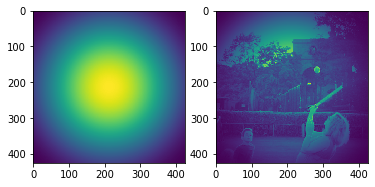

In [9]:
# trying out "mask" for circular edges - might be useful for defining RFs?
x,y = np.meshgrid(np.arange(0,np.shape(nsd_im)[0]), (np.arange(0,np.shape(nsd_im)[0])))
center = np.median(x)
dist_from_center = np.sqrt((x-center)**2+(y-center)**2)
dist_from_center = dist_from_center/np.max(dist_from_center)*(np.pi)
cos_mask = (np.cos(dist_from_center)+1)/2
# goes from 0 at corner, to 1 at center
plt.figure();
plt.subplot(1,2,1)
plt.pcolormesh(cos_mask)
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
image_masked = nsd_im*np.tile(np.expand_dims(cos_mask,2),[1,1,3])
plt.pcolormesh(image_masked[:,:,0])
plt.axis('square')
plt.gca().invert_yaxis()

In [17]:
# Test filtering for a COCO/NSD image

im2use = nsd_im
# print(np.shape(im2use))
freqs_cpp = [0.1];
orients_deg = [0,30,60,90]

bank = l.filter_bank(orients_deg, freqs_cpp, spat_aspect_ratio=1)
# filts, orient_labs, freq_labs = bank.get_filters_freq()
# np.shape(filts)
t = time.time()
image_stats, filters = l.filter_whole_image_spat(im2use, bank)
elapsed = time.time() - t
print('elapsed time is %.2f sec'%elapsed)
t = time.time()
image_stats, filters = l.filter_whole_image_freq(im2use, bank)
elapsed = time.time() - t
print('elapsed time is %.2f sec'%elapsed)
orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']

n

elapsed time is 2.00 sec
None
[425 425]
elapsed time is 1.62 sec


(425, 425, 4)

time elapsed: 1.29 sec


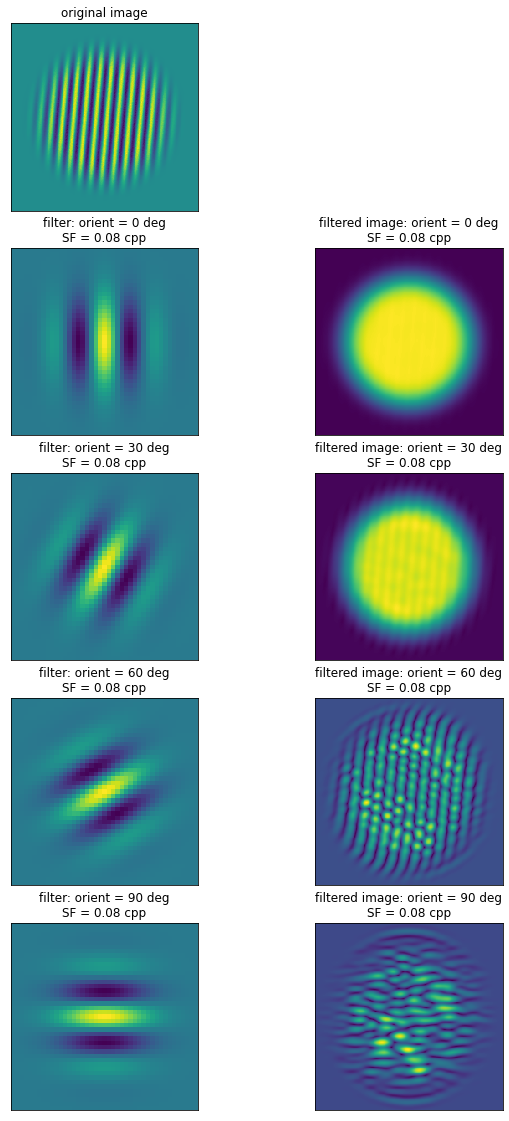

In [20]:
# Test filtering for a grating image, in spatial domain

im2use = grating_im

freqs_cpp = [0.08];
orients_deg = [0,30,60,90]

bank = l.filter_bank(orients_deg, freqs_cpp)

t=time.time()
image_stats, filters = l.filter_whole_image_spat(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)


orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']

plt.figure(figsize=(10,20));

plt.subplot(5,2,1)
plt.pcolormesh(im2use[:,:,0])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(4):
    
    kernel = filters[ii]
    filtered = image_stats['mag'][:,:,ii]
  
    plt.subplot(5,2,3+2*ii)
    plt.pcolormesh(np.real(kernel))

    plt.axis('square')
    plt.title('filter: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    
    plt.subplot(5,2,4+2*ii)
    plt.pcolormesh(filtered)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

[224, 224]
[224 224]
time elapsed: 0.37 sec


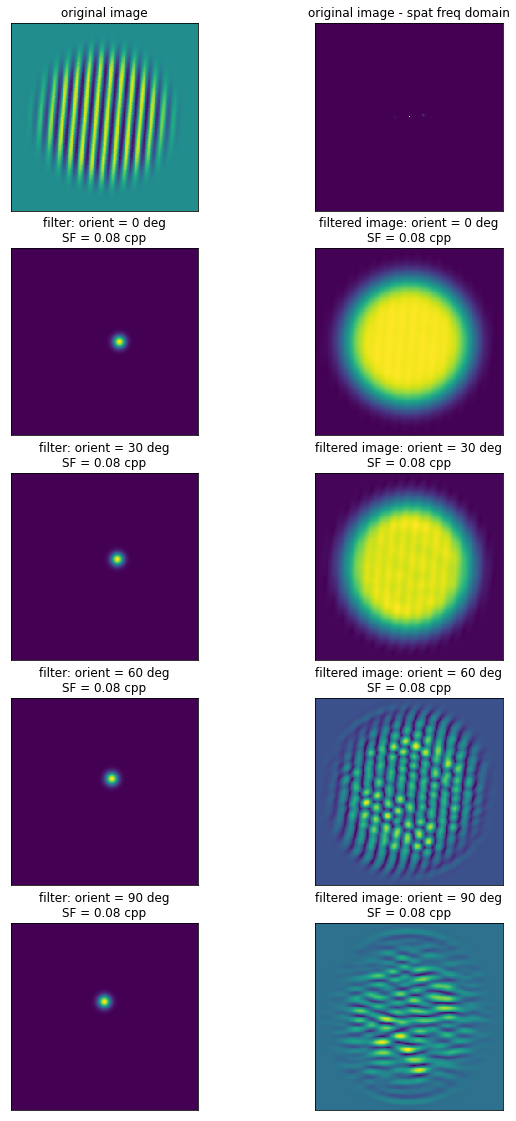

In [31]:
# Test filtering for a grating image, in the spatial frequency domain (should be about same as above but faster)

im2use = grating_im

orients_deg = [0,30,60,90]
freqs_cpp = [0.08]
padded_size=(224,224)
params = {'orig_size': (224,224), 'size_after_pad': padded_size}


bank = l.filter_bank(orients_deg, freqs_cpp, image_size = [224,224])

t=time.time()
image_stats, filters = l.filter_whole_image_freq(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)

orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']

plt.figure(figsize=(10,20));

plt.subplot(5,2,1)
plt.pcolormesh(im2use[:,:,0])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')


plt.subplot(5,2,2)
plt.pcolormesh(np.abs(fft.fftshift(fft.fft2(im2use[:,:,0]))))
plt.axis('square')
plt.title('original image - spat freq domain')
plt.xticks([])
plt.yticks([])

for ii in range(4):
    
    plt.subplot(5,2,3+2*ii)
    plt.pcolormesh(np.abs(filters[:,:,ii]))
    plt.axis('square')
    plt.title('filter: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(5,2,4+2*ii)
#     plt.pcolormesh(np.real(filter_stack_freq[:,:,ii]))
    plt.pcolormesh(image_stats['mag'][:,:,ii])
#     plt.colorbar()
#     plt.pcolormesh(np.abs(filters[:,:,ii]))
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

time elapsed: 14.35 sec
(425, 425)
[425 425]
time elapsed: 1.60 sec


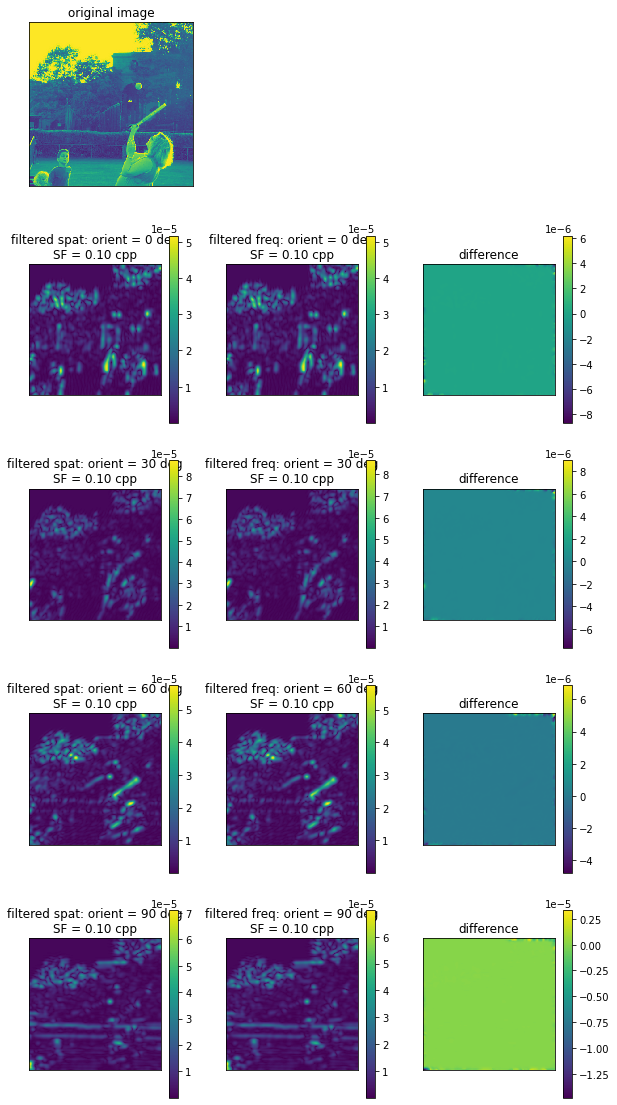

In [32]:
# Test filtering for a COCO/NSD image, compare spatial and frequency methods

im2use = nsd_im

freqs_cpp = [0.10];
orients_deg = [0,30,60,90]

bank = l.filter_bank(orients_deg, freqs_cpp, spat_aspect_ratio = 1, n_sd_out = 7, image_size=np.shape(nsd_im)[0:2])

t=time.time()
image_stats1, filters = l.filter_whole_image_spat(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)

t=time.time()
image_stats2, filters = l.filter_whole_image_freq(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)

orient_labs = image_stats1['orient_labs']
freq_labs = image_stats1['freq_labs']

plt.figure(figsize=(10,20));

plt.subplot(5,3,1)
plt.pcolormesh(im2use[:,:,0])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(4):
 
    filtered1 = image_stats1['mag'][:,:,ii]/np.sum(image_stats1['mag'][:,:,ii])
    filtered2 = image_stats2['mag'][:,:,ii]/np.sum(image_stats2['mag'][:,:,ii])

    plt.subplot(5,3,4+3*ii)
    plt.pcolormesh(filtered1)
    plt.axis('square')
    plt.title('filtered spat: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    plt.colorbar()
    
    plt.subplot(5,3,5+3*ii)
    plt.pcolormesh(filtered2)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered freq: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
    plt.subplot(5,3,6+3*ii)
    plt.pcolormesh(filtered1-filtered2)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('difference')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

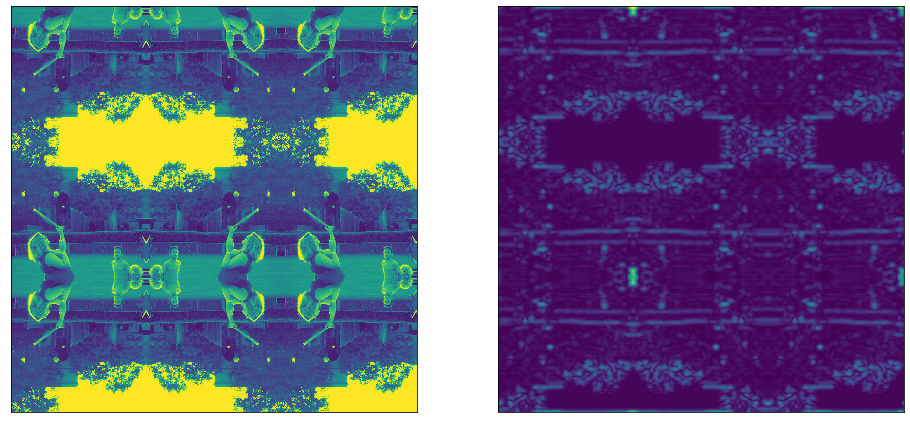

In [28]:
# Visualizing how the reflected padding/filtering works out.

filters_freq, orient_labs, freq_labs = bank.get_filters_freq()
size_after_pad = np.array([np.shape(filters_freq)[0], np.shape(filters_freq)[1]])
grey_image = np.round(np.mean(im2use,axis=2),0);
image = grey_image;
orig_size = np.shape(grey_image)
pad_by = (size_after_pad - orig_size)/2   
n2pad = np.transpose(np.array([np.floor(pad_by),np.ceil(pad_by)]).astype('int'));   
# n2pad goes [[x1, x2],[y1, y2]]
# padding with reflection instead of zeros, avoid edge artifacts!
image_padded = np.pad(grey_image,n2pad,mode='reflect')
# Filtering:
# fft into frequency domain
image_fft = fft.fftshift(fft.fft2(image_padded,axes=[0,1]));

# Apply all my filters all at once
filtered_freq_domain = np.tile(np.expand_dims(image_fft,2),[1,1,np.shape(filters_freq)[2]])*filters_freq;

# get back to the spatial domain
out_full = fft.ifft2(filtered_freq_domain,axes=[0,1]);

plt.figure(figsize=(16,16));

plt.subplot(1,2,1)
plt.pcolormesh(image_padded)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.pcolormesh(np.abs(out_full[:,:,3]))
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

time elapsed: 22.33 sec


ValueError: num must be 1 <= num <= 10, not 12

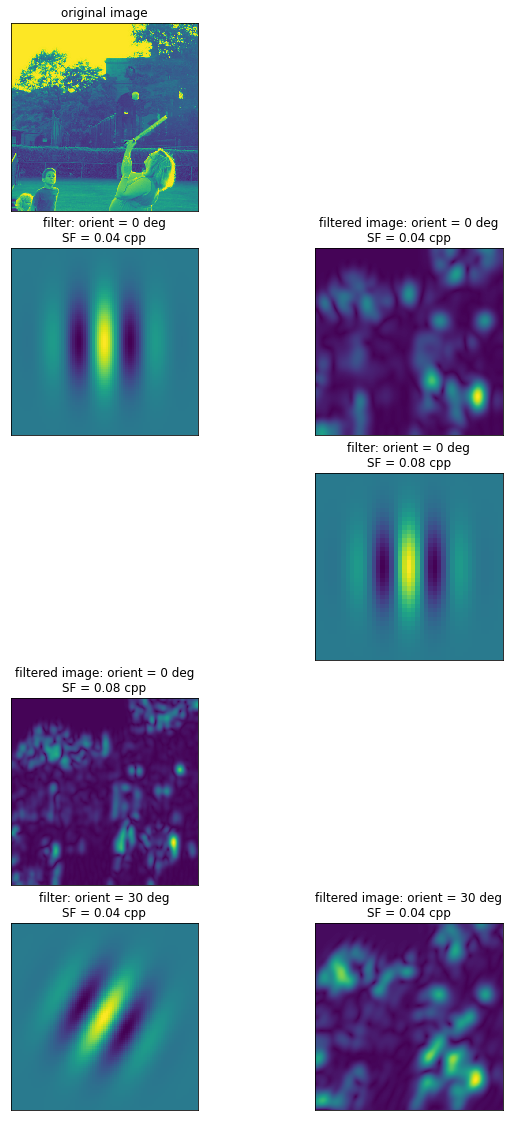

In [30]:
# Test filtering for a COCO/NSD image, in spatial domain

im2use = nsd_im

freqs_cpp = [0.04, 0.08];
orients_deg = [0,30,60,90]

bank = l.filter_bank(orients_deg, freqs_cpp, spat_aspect_ratio = 1, n_sd_out = 3)

t=time.time()
image_stats, filters = l.filter_whole_image_spat(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)

orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']

plt.figure(figsize=(10,20));

plt.subplot(5,2,1)
plt.pcolormesh(im2use[:,:,0])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')

for ii in range(4):
    
    kernel = filters[ii]
    filtered = image_stats['mag'][:,:,ii]
#     orient_rad = orients_deg[ii]/180*np.pi
#     kernel = l.makeSpatGabor(orients_deg[ii], freq_cpp, spat_freq_bw=1, spat_aspect_ratio=1)
#     filtered = ndi.convolve(im2use[:,:,0], kernel, mode='reflect')
    
    plt.subplot(5,2,3+3*ii)
    plt.pcolormesh(np.real(kernel))
    plt.axis('square')
    plt.title('filter: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    
    plt.subplot(5,2,4+3*ii)
    plt.pcolormesh(filtered)
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

7
size of patch needed is:
[99. 99.]
sigma_x, sigma_y:
[7.027148442347908, 7.027148442347908]
biggest filter will be:
[475 475]
using your manually specified filter size
size of patch needed is:
[99. 99.]
sigma_x, sigma_y:
[7.027148442347908, 7.027148442347908]
using your manually specified filter size
size of patch needed is:
[99. 99.]
sigma_x, sigma_y:
[7.027148442347908, 7.027148442347908]
using your manually specified filter size
size of patch needed is:
[99. 99.]
sigma_x, sigma_y:
[7.027148442347908, 7.027148442347908]
using your manually specified filter size
size of patch needed is:
[99. 99.]
sigma_x, sigma_y:
[7.027148442347908, 7.027148442347908]
time elapsed: 0.32 sec
(475, 475, 4)


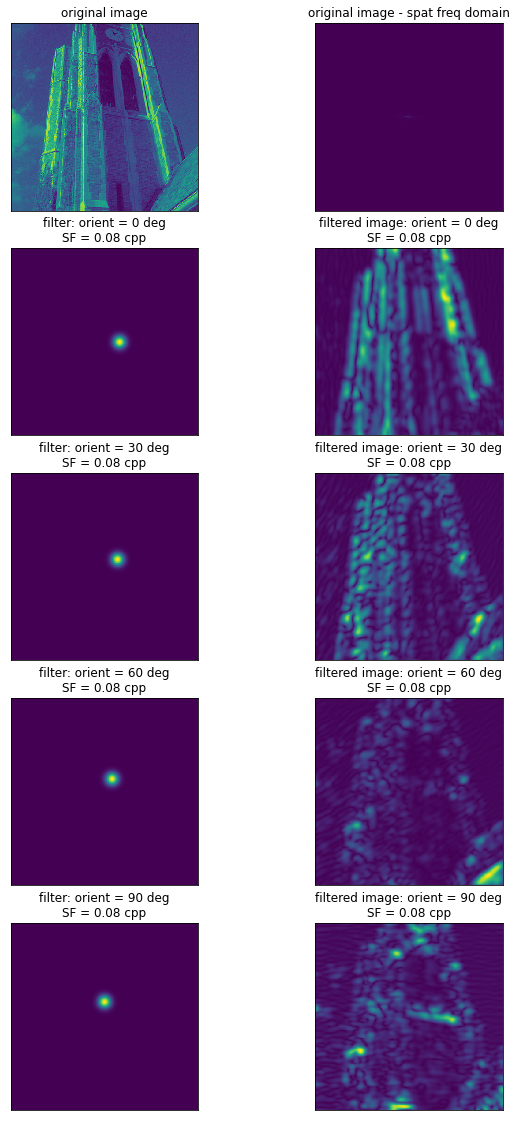

In [9]:
# Test filtering for a COCO/NSD image, in the spatial frequency domain (should be same as above but faster)

im2use = nsd_im

orients_deg = [0,30,60,90]
freqs_cpp = [ 0.08]

bank = l.filter_bank(orients_deg, freqs_cpp, spat_aspect_ratio = 1, n_sd_out = 7, image_size=(425,425))
print(bank.n_sd_out)

t=time.time()
image_stats, filters = l.filter_whole_image_freq(im2use, bank)
elapsed = time.time() - t
print('time elapsed: %.2f sec'%elapsed)
print(np.shape(filters))
orient_labs = image_stats['orient_labs']
freq_labs = image_stats['freq_labs']

plt.figure(figsize=(10,20));

plt.subplot(5,2,1)
plt.pcolormesh(im2use[:,:,0])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.title('original image')


plt.subplot(5,2,2)
plt.pcolormesh(np.abs(fft.fftshift(fft.fft2(im2use[:,:,0]))))
plt.axis('square')
plt.title('original image - spat freq domain')
plt.xticks([])
plt.yticks([])

for ii in range(4):
    
    plt.subplot(5,2,3+2*ii)
    plt.pcolormesh(np.abs(filters[:,:,ii]))
    plt.axis('square')
    plt.title('filter: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(5,2,4+2*ii)
#     plt.pcolormesh(np.real(filter_stack_freq[:,:,ii]))
    plt.pcolormesh(image_stats['mag'][:,:,ii])
#     plt.colorbar()
#     plt.pcolormesh(np.abs(filters[:,:,ii]))
    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.title('filtered image: orient = %d deg\nSF = %.2f cpp'%(orient_labs[ii],freq_labs[ii]))
    plt.xticks([])
    plt.yticks([])

size of patch needed is:
[33. 67.]
sigma_x, sigma_y:
[5.460963012133131, 10.921926024266263]
drawing center at:
[33. 33.]
(67, 67)
size of patch needed is:
[33. 67.]
sigma_x, sigma_y:
[5.460963012133131, 10.921926024266263]


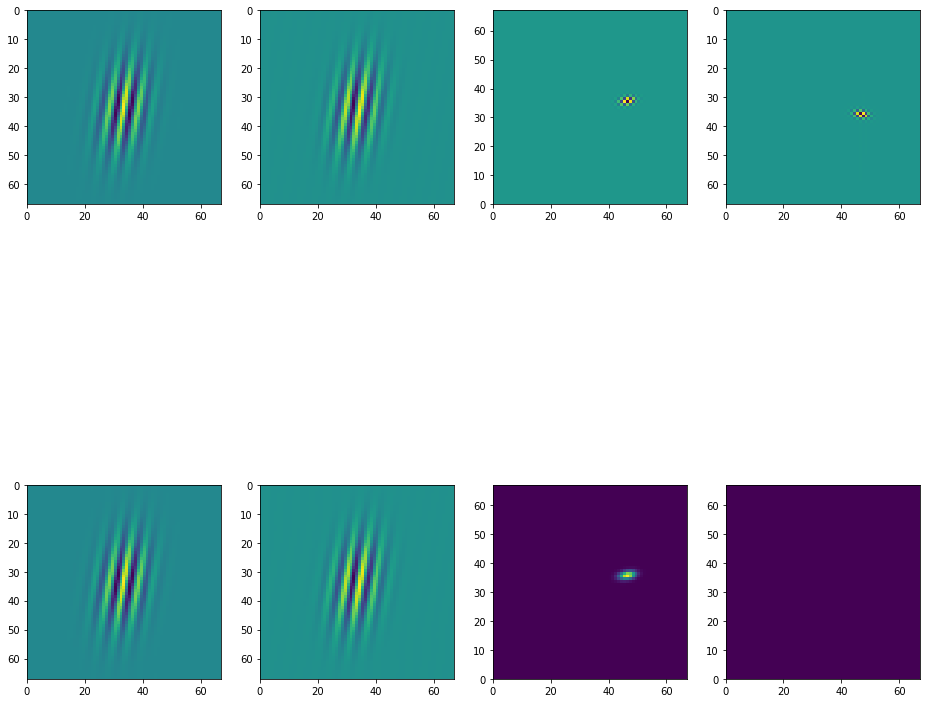

In [3]:
# Comparing frequency domain and spatial domain rep of gabor filters
# Want to make sure you can go back and forth without any issues.

orient_deg=10
freq_cpp = 0.2;

plt.figure(figsize=(16,16));

# Method 1: make a gabor in spatial domain, fft to frequency domain

gabor_spat1 = l.makeSpatGabor(orient_deg, freq_cpp, spat_freq_bw=0.5, spat_aspect_ratio=0.5, n_sd_out=3)
# gabor_spat1 = gabor_kernel(frequency=freq_cpp, theta=orient_deg/180*np.pi,bandwidth = 1, n_stds=3)
gabor_freq1 = fft.fftshift(fft.fft2(gabor_spat1))
gabor_spat1_new = fft.ifft2(fft.ifftshift(gabor_freq1))

print(np.shape(np.real(gabor_spat1)))
plt.subplot(2,4,1)
plt.pcolormesh(np.real(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()
# flipping the y axis here - so positive orientation is rotating clockwise from vertical.

plt.subplot(2,4,2)
plt.pcolormesh(np.imag(gabor_spat1))
plt.axis('square')
plt.gca().invert_yaxis()

plt.subplot(2,4,3)
plt.pcolormesh(np.real(gabor_freq1))
plt.axis('square')

plt.subplot(2,4,4)
plt.pcolormesh(np.imag(gabor_freq1))
plt.axis('square')
plt.gca().invert_yaxis()
# flipping the y axis here - so positive orientation is rotating clockwise from vertical.


# Method 2: make a gabor in frequency domain, then convert back to spatial

gabor_freq2 = l.makeFreqGabor(orient_deg, freq_cpp, spat_freq_bw=0.5, spat_aspect_ratio=0.5, n_sd_out=3)
gabor_spat2 = fft.fftshift(fft.ifft2(fft.ifftshift(gabor_freq2)))

plt.subplot(2,4,7);
plt.pcolormesh(np.real(gabor_freq2))
plt.axis('square')

plt.subplot(2,4,8);
plt.pcolormesh(np.imag(gabor_freq2))
plt.axis('square')
# positive orientation in SF domain is counter-clockwise from rightmost pt.

plt.subplot(2,4,5);
plt.pcolormesh(np.real(gabor_spat2))
plt.axis('square')
plt.gca().invert_yaxis()

# positive orientation is rotating clockwise from vertical.
plt.subplot(2,4,6)
plt.pcolormesh(np.imag(gabor_spat2))
plt.axis('square')
plt.gca().invert_yaxis()

